In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.graph_objects as go
import yfinance as yf
from scipy.signal import argrelextrema

In [2]:
stock = yf.Ticker("AMD")
hist = stock.history(period='1y', interval='1d')

In [3]:
print(hist.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-06-30 to 2021-06-29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          252 non-null    float64
 1   High          252 non-null    float64
 2   Low           252 non-null    float64
 3   Close         252 non-null    float64
 4   Volume        252 non-null    int64  
 5   Dividends     252 non-null    int64  
 6   Stock Splits  252 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 15.8 KB
None


In [4]:
def plot_price_history(price_df):
    fig = go.Figure(data=[go.Candlestick(x=price_df.index,
                    open=price_df['Open'],
                    high=price_df['High'],
                    low=price_df['Low'],
                    close=price_df['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

In [5]:
plot_price_history(hist)

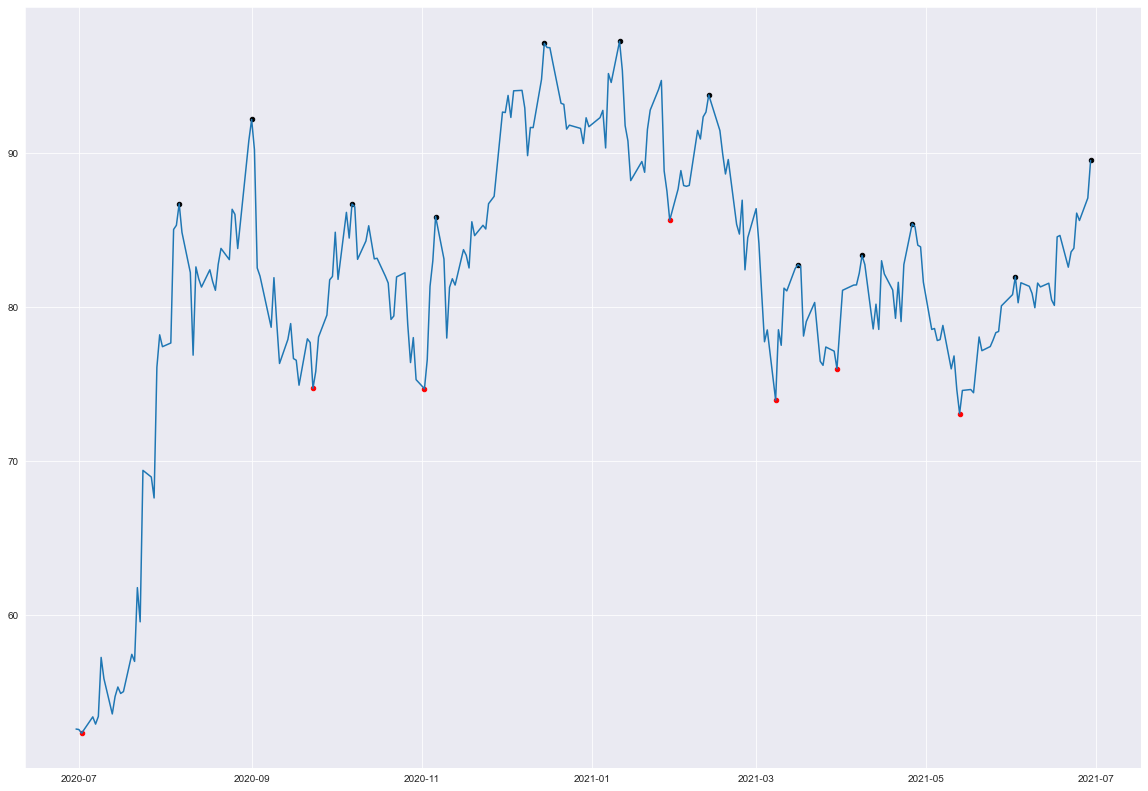

In [6]:
n = 9
hist['Min'] = hist.Close.iloc[argrelextrema(hist.Close.values, np.less_equal, order=n)[0]]
hist['Max'] = hist.Close.iloc[argrelextrema(hist.Close.values, np.greater_equal, order=n)[0]]

plt.figure(figsize=(20,14))
plt.plot(hist.index, hist.Close)
plt.scatter(hist.index, hist.Min, c='red', s=20)
plt.scatter(hist.index, hist.Max, c='black', s=20)

In [7]:
hist['Min_or_Max'] = hist.Max.combine_first(hist.Min)
hist_range = hist.Close.max() - hist.Close.min()
tol = hist_range / hist.Close.std()
req_points = int(hist_range / hist.Close.std())
print(req_points)
print(str(tol) + "\n")
print(hist.Close.describe())
levels = []

min_max_vals = hist.Min_or_Max.sort_values(ascending=False).tolist()
current_level = min_max_vals[0]

cluster = []
# Points that are near the top or bottom of the data are more important
weighted_cluster_size = 0
for i in range(1, len(min_max_vals)):
    if abs(min_max_vals[i] - current_level) <= tol:
        cluster.append(min_max_vals[i])

        weighted_cluster_size += 1
        # Extra weighting for extreme points
        if i <= 4 or i >= len(min_max_vals) - 5:
            weighted_cluster_size += 1

    else:
        if weighted_cluster_size >= req_points:
            levels.append(np.array(cluster).mean())

        current_level = min_max_vals[i]        
        cluster = []
        weighted_cluster_size = 0


4
4.902725334257673

count    252.000000
mean      81.656468
std        9.160211
min       52.340000
25%       78.179998
50%       82.174999
75%       86.709999
max       97.250000
Name: Close, dtype: float64


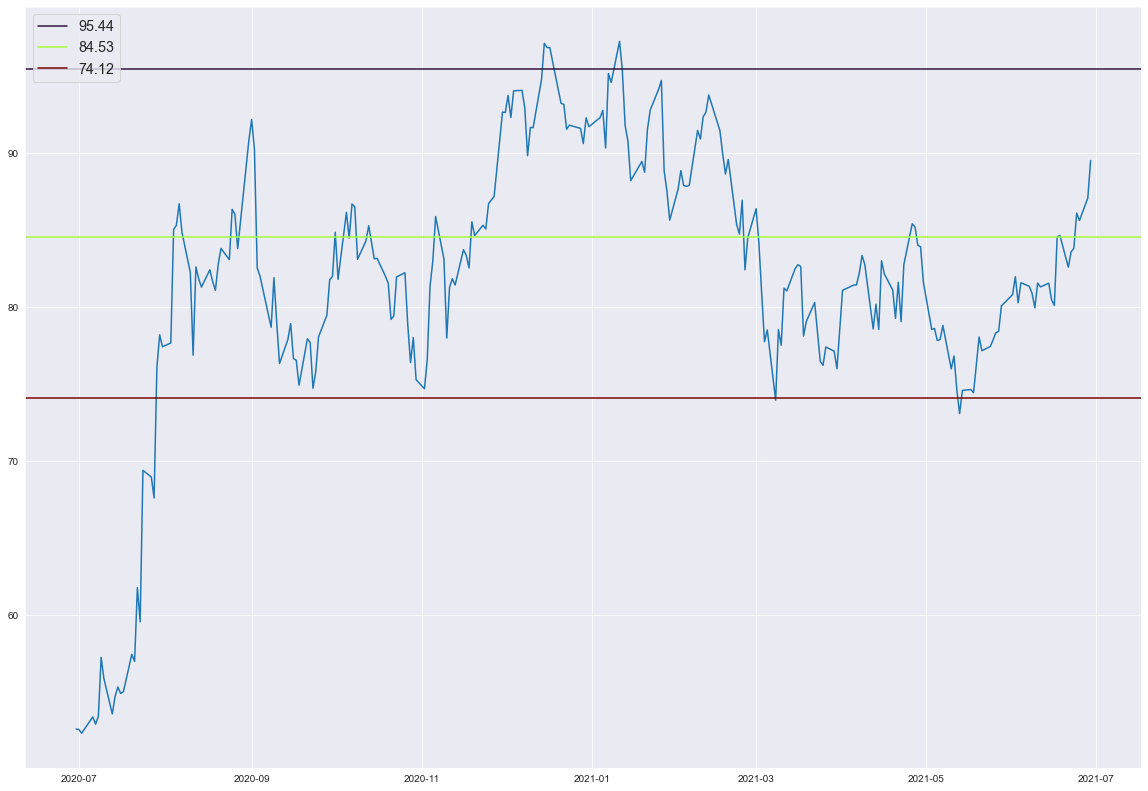

In [8]:
if len(levels) > 0:
    plt.figure(figsize=(20,14))
    plt.plot(hist.index, hist.Close)

    color=iter(plt.cm.turbo(np.linspace(0,1,len(levels))))
    for level in levels:
        c=next(color)
        plt.axhline(level, color=c, label="{:5.2f}".format(level))

    plt.legend(loc='upper left', fontsize='x-large')
    plt.show()
else:
    print('No support or resistance levels found!')